# Functions for detecting peaks from ECG signals

In [300]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import math
import statistics
import neurokit2 as nk
from scipy.signal import butter, filtfilt, iirnotch, savgol_filter
import scipy.signal
import peakutils.peak
import seaborn as sns
import pywt as pw

In [2]:
%run "Pan_Tomkins_Algorithm_Final.ipynb"

In [3]:
def butter_lowpass(cutoff, sample_rate, order=2):
    """
    The function returns the butter indexes for a butter lowpass filter. Github https://github.com/paulvangentcom/heartrate_analysis_python/tree/0005e98618d8fc3378c03ab0a434b5d9012b1221 
    
    Input: cutoff-frequency from which the values will be filtered out; order-stregnth of the filter; sample_rate-rate at which the signal was sampled.
    
    Ouput: butter indeces.

    """
    nyq = 0.5 * sample_rate
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_highpass(cutoff, sample_rate, order=2):
    """
    The function returns the butter indexes for a highpass filter. Github https://github.com/paulvangentcom/heartrate_analysis_python/tree/0005e98618d8fc3378c03ab0a434b5d9012b1221 
    
    Input: cutoff-frequency from which the values will be filtered out; order-stregnth of the filter; sample_rate-rate at which the signal was sampled.
    
    Ouput: butter indeces.

    """
    nyq = 0.5 * sample_rate
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

In [4]:
def filter_signal(data, cutoff, sample_rate, order=2, filtertype='lowpass'):
    """
    The function filters data in the frequency domain. 
    
    Input: data-signal data stored in an array; cutoff-frequency from which the values will be filtered out; order-stregnth of the filter; filtertype-type of filter:
        lowpass,highpass,bandpass,notch
    
    Ouput: filtered_data

    """
    
    if filtertype.lower() == 'lowpass':
        b, a = butter_lowpass(cutoff, sample_rate, order=order)
    elif filtertype.lower() == 'highpass':
        b, a = butter_highpass(cutoff, sample_rate, order=order)
    elif filtertype.lower() == 'bandpass':
        assert type(cutoff) == tuple or list or np.array, 'if bandpass filter is specified, \
cutoff needs to be array or tuple specifying lower and upper bound: [lower, upper].'
        b, a = butter_bandpass(cutoff[0], cutoff[1], sample_rate, order=order)
    elif filtertype.lower() == 'notch':
        b, a = iirnotch(cutoff, Q = 0.005, fs = sample_rate)
    else:
        raise ValueError('filtertype: %s is unknown, available are: \
lowpass, highpass, bandpass, and notch' %filtertype)

    filtered_data = filtfilt(b, a, data)
    
    return filtered_data

In [5]:
def remove_baseline_wander(data, sample_rate, cutoff=0.05):
    """
    The functions removes the signal's baseline.
    Input: data-signal stored in an array; sample_rate: sample rate in which the signal was sampled; cutoff-frequency frequency from which the values will be filtered out.
    Output: corrected signal.
    """
    return filter_signal(data = data, cutoff = cutoff, sample_rate = sample_rate,
                         filtertype='notch')

In [6]:
def cos_correction(signal):
    """
    The function removes a tenth of both ends from the signal by multiplying it by a half cosine function.
    Input: signal-index of data points to be corrected.
    Output: even signal with the corners diminished. 
    """
    length = len(signal) # We find the length of the signal.
    signal_10 = 0.01*length # We calculate the length of a tenth of the signal.
    signal_90 = length - signal_10 # We calculate the difference to know the tenth corresponding to the array's final end.
    step = (np.pi/2)/signal_10 # We find the number of values our cosine function needs to have.

    x = np.arange(0,np.pi/2,step) # We generate half a cosine function: start,stop,step
    y = np.cos(x)
    cos_end = y

    y = np.cos(x-1.57) # We shift it by pi so we can use it as a smoothening factor to apply to the values at the end of the signal.
    cos_init = y

    for index,value in enumerate(cos_init):
        signal[index] = signal[index]*value # We perform the multiplicatoin by the signal points and the cosine points.

    for value, index in zip((signal[int(signal_90):]), cos_end):
        signal[int(-index)] = value * index
    return signal

In [7]:
def scale_data(data, lower=0, upper=1024):
    """
    Subfunction from the enhance_peaks section. It allows to scale the data.
    Input: data-the signal, lower,upper-ranges that describe the scaling factor.
    Output: scaled signal. 
    """
    rng = np.max(data) - np.min(data)
    minimum = np.min(data)
    data = (upper - lower) * ((data - minimum) / rng) + lower
    return data

In [8]:
def enhance_peaks(hrdata, iterations=2):
    """
    The function squares the signal and, hence, enhances the peaks.
    Input: hrdata-the signal stored in an array; iterations-the times the signal is squared.
    Output: enhanced signal. 
    """
    scale_data(hrdata)
    for i in range(iterations):
        hrdata = np.power(hrdata, 2)
        hrdata = scale_data(hrdata)
    return hrdata 

In [9]:
def smoothing_window(signal):
    """
    The function creates a sliding window and it is used to smooth the signal out by an average mean.
    Input: signal-the signal stored in an array.
    Output: smoothened signal. 
    """
    #Define window size
    w=31
    #Define mask and store as an array
    mask=np.ones((1,w))/w
    mask=mask[0,:]

    #Convolve the mask with the raw data
    convolved_data=np.convolve(signal,mask,'same')
    return convolved_data

In [135]:
def _filtering(signal,rate):
    """
    Application of a sub-sequent filtering steps, based on the Pan-Tomkins peak scalation for subsequent peak detection. 
    Input: signal-the signal stored in an array; rate-the sampling frequency at which the signal was sampled.
    Output: filtered signal. 
    """
    #cos_removed = cos_correction(signal) # We remove the points located at both ends of the signal.
    low = filter_signal(signal, 40, rate, order=4, filtertype='lowpass') # We apply a low-pass filter.
    high = filter_signal(low,0.5, rate, order=4, filtertype='highpass') # We apply a high-pass filter.
    plt.plot(high)
    plt.title("High")
    plt.show()
    coeffs = pw.swt(high, wavelet = "haar", level=2, start_level=0, axis=-1)
    wv = coeffs[1][1] ##2nd level detail coefficients
    wv = wv[1:9999]
    plt.plot(wv)
    plt.title("Wv")
    plt.show()
    convolved = smoothing_window(wv)
    plt.plot(convolved)
    plt.title("convolved")
    plt.show()
    #remove = remove_baseline_wander(convolved, rate) # We remove the signal's baseline.
    en = enhance_peaks(convolved, iterations=4) # We enhance the signal twice to improve the following peak-detection.
    
    return en



In [299]:
def _peakdetection(signal):
    
    """
    
    The funtion detects the peaks based on a threshold algorithm described in the following paper:
    https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7922324/. The algorithm has been tunned to incorporate a sliding threshold
    that accounts for enhanced peaks. 
    
    Input: signal-the signal we would like to obtain the peaks from.
    Output: a dataframe containing the x and y values corresponding to the different peaks detected.
    
    """
    
    peaks = pd.DataFrame()
    y_points = [] # List where we are going to store the y_values of the peaks detected.
    x_points = [] # List where we are going to store the x_values of the peaks detected.
    temp = 0.5*((0.75*np.percentile(signal, 90))+(0.25*np.mean(signal))) #+ np.std(signal) # We define the threshold.
    for index,point in enumerate(signal): 
        if point > temp: # We check if the value is bigger than the threshold. If it is the case, we set it as the new threshold.
            threshold = point
            if signal[index+1]< threshold and (signal[index]-signal[index-1]) > 0:# If the next value is lower than the threshold, then we add the point as detected and we restart the threshold.
                if point > signal[index-1] and point > signal[index+1]:
                    y_points.append(point) # We add the difference between the values because the first condition will detect all the points on the QRS complex, we need to not save the lower points on the peak's slope.
                    x_points.append(index)
        if point < temp: # Once the peak is stored, we restart the threshold value to calculate the following peak.
            threshold = temp
            
    diff = np.diff(x_points)
    x_del = []
    y_del = []
    for index,value in enumerate(diff):
        if value < 200:
            x_del = np.append(x_del,index)
    
    x_del = [ int(val) for val in x_del ]
   
    x_points = np.delete(x_points,x_del)
    y_points = np.delete(y_points,x_del)

    peaks['x_values'] = x_points
    peaks['y_values'] = y_points
    print(peaks)
    
    return peaks
    
    

In [292]:
def _filteringdet(signal,rate):
    normalised = (signal - np.min(signal)) / np.max(signal-np.min(signal))
    filtered = _filtering(signal,rate)
    plt.plot(normalised[0:5000])
    plt.show()
    plt.plot(filtered[0:5000])
    plt.show()
    peaks = _peakdetection(filtered)
    
    return peaks

In [293]:
def _filteringdetpeak(signal,rate):
    normalised = (signal - np.min(signal)) / np.max(signal-np.min(signal))
    filtered = _filtering(signal,rate)
    plt.plot(normalised[0:5000])
    plt.show()
    plt.plot(filtered[0:5000])
    plt.show()
    temp = 0.5*((0.75*np.percentile(signal, 90))+(0.25*np.mean(signal)))
    peaks = peakutils.peak.indexes(np.array(filtered), thres = temp, min_dist=10)
    df_peaks = pd.DataFrame()
    df_peaks['x_values'] = peaks
    y_values = []
    for point in peaks:
        value = np.interp(point, np.arange(0,len(signal),1), signal)
        y_values.append(value)
    df_peaks['y_values'] = y_values
    
    return df_peaks

In [294]:
def _pantompkinspeaks(signal,rate):
    normalised = (signal - np.min(signal)) / np.max(signal-np.min(signal))
    filtered = _filtering(normalised,rate)
    plt.plot(normalised[0:5000])
    plt.show()
    plt.plot(filtered[0:5000])
    plt.show()
    peaks = _peak_detection(filtered,rate)
    corrected_peaks = _correct_peaks(normalised,rate,peaks)
    df_peaks = pd.DataFrame()
    df_peaks['x_values'] = corrected_peaks
    y_values = []
    for point in corrected_peaks:
        value = np.interp(point, np.arange(0,len(normalised),1), normalised)
        y_values.append(value)
    df_peaks['y_values'] = y_values
    
    return df_peaks
    

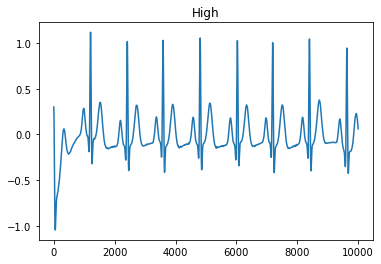

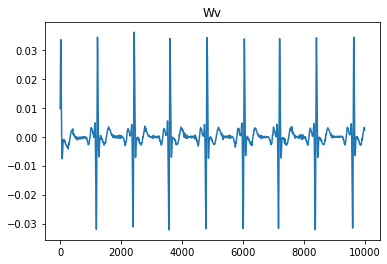

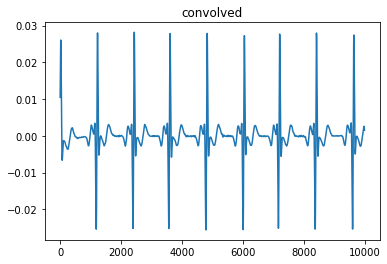

[20, 1185, 1227, 2392, 2434, 3567, 3609, 4786, 4828, 6009, 6051, 7168, 7210, 8376, 8419, 9605, 9646]
marker
   x_values     y_values
0        20   292.691440
1      1227   919.946365
2      2434  1024.000000
3      3609   829.164648
4      4828   853.295696
5      6051   598.409070
6      7210   770.954764
7      8419   898.065865
8      9646   655.181579


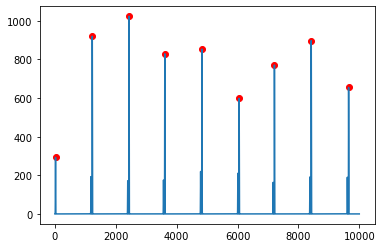

In [298]:
fil = _filtering(ecg50,1000)
plt.plot(fil)
peaks = _peakdetection(fil)
plt.scatter(peaks['x_values'],peaks['y_values'],marker='o',color='r')